# Simple example reconstructing the sin function


## Imports and dataset

2023-02-14 16:18:45.371210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 16:18:46.500140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-02-14 16:18:46.500306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-02-14 16:18:46.500314: W tensorflow/compiler/tf2tensorrt/utils/py_utils

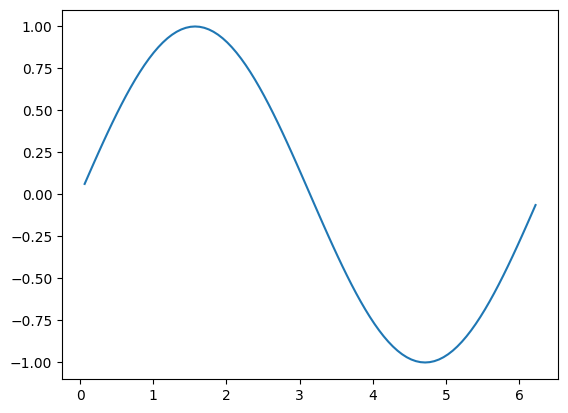

In [1]:
import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import sklearn.metrics

X = []
Y = []

num_samples = 100

for i in range(1, num_samples):
    X.append(2.0*math.pi/num_samples * float(i))
    Y.append(math.sin(2.0*math.pi/num_samples * float(i)))

plt.plot(X, Y)
plt.show()

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.reshape(-1, 1)

dataset = HPO.Dataset(X, Y)


## Grid search

In [6]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_shape=(1,), activation='relu'))
    model.add(Dense(1, activation=None))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasRegressor(model=create_model, verbose=0)

hyperparameterspace = {
    'batch_size' : [2, 30],
    'epochs': [1, 300]
}

optimization = HPO.Optimization(dataset, model, hyperparameterspace, type=0)
result = optimization.fit()
print("Best result:")
print(result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X))

plt.plot(X,Y)
plt.show()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])


## Random search

Best result:
-26.93586512718853
Corresponding parameters:
{'epochs': 40, 'batch_size': 40}


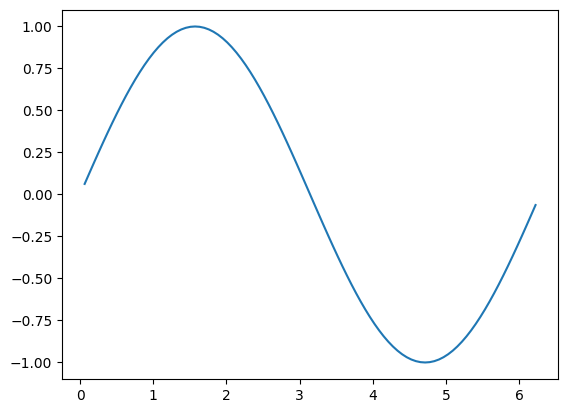

In [3]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_shape=(1,), activation='relu'))
    model.add(Dense(1, activation=None))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasRegressor(model=create_model, verbose=0)

hyperparameterspace = {
    'batch_size' : [10, 20, 40],
    'epochs': [1, 20, 40, 60]
}

optimization = HPO.Optimization(dataset, model, hyperparameterspace, type=1)
result = optimization.fit()
print("Best result:")
print(result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

plt.plot(X,Y)
plt.show()

## Bayesian Optimization 

https://thuijskens.github.io/2016/12/29/bayesian-optimisation/ 

Progress: [####################] 100.0%
Current time per iteration: 1.6789475349978602
Approx. time remaining: 0.0
Best MSE:
-0.44026986
With Hyperparameters: 
[array([7.27629260e-03, 3.69015443e+01])]


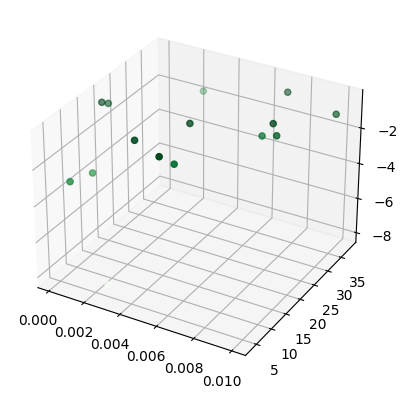

In [4]:
def blackboxfunction(params):
    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(12, input_shape=(1,), activation='relu'))
        model.add(Dense(1, activation=None))
        # Compile model
        opt = keras.optimizers.Adam(learning_rate=params[0])
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    model = KerasRegressor(model=create_model, verbose=0)

    model.fit(X, Y, epochs=int(params[1]))

    Y_predicted = model.predict(X)

    return -sklearn.metrics.mean_squared_error(Y, Y_predicted)


hyperparameterspace = np.array([[0.0001, 0.01], [1,60]])

optimization = HPO.Optimization(dataset, blackboxfunction, hyperparameterspace, type=2)
result = optimization.fit()

fig = plt.figure()
ax = plt.axes(projection='3d')

x = [result[0][i][0] for i in range(len(result[0]))]
y = [result[0][i][1] for i in range(len(result[0]))]

ax.scatter3D(x, y, result[1], c=result[1], cmap='Greens')

print("Best MSE:")
print(max(result[1]))
print("With Hyperparameters: ")
print([result[0][i] for i in range(len(result[0])) if result[1][i] == max(result[1])])
#print(result)

## Sparse grid search

Adaptive grid generation (Ritter-Novak)...


2023-02-14 16:18:49.056102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-14 16:18:49.056197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maxi-XPS-15-9560): /proc/driver/nvidia/version does not exist
2023-02-14 16:18:49.057734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done in 409663ms.
Solving linear system (automatic method)...
Done in 9ms.

Optimal hyperparameters so far:
Epochs:  271.96875
learning_rate:  0.0075025000000000005
Resulting loss:
0.3083241452574479
Optimizing (gradient descent)...
Done in 0ms.
[9.52491306798262771238e-01, 9.99999807111271676874e-01]

Optimal hyperparameters after optimization:
Epochs:  299.99994232627023
learning_rate:  0.009525388154914645
Resulting loss (Optimal value from optimization):
-24.07029395862052
Resulting loss (Optimal point evaluated):
0.4351776207068606


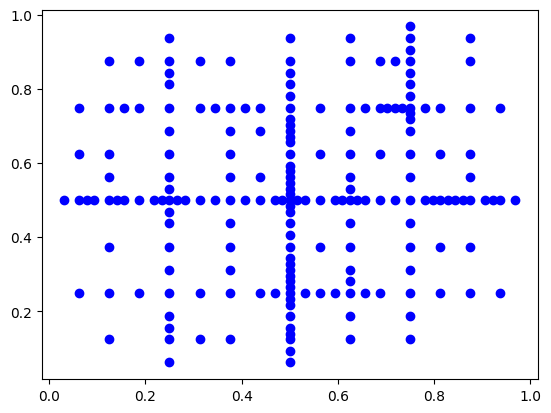

In [2]:
hyperparameterspace = {
    'learning_rate' : [0.00001, 0.01],
    'epochs': [1, 300]
}

def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):

        epochs = int(from_standard(1, 300, x[1]))
        learning_rate  = int(from_standard(0.01, 0.00001, x[0]))
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(12, input_shape=(1,), activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            opt = keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(X, Y, epochs=epochs)
        Y_predicted = model.predict(X)

        return sklearn.metrics.mean_squared_error(Y.tolist(), Y_predicted.tolist())
################################## generate Grid ##################################

pysgpp.omp_set_num_threads(1)

pysgpp.Printer.getInstance().setVerbosity(0)

f = ExampleFunction()

optimization = HPO.Optimization(dataset, f, hyperparameterspace, type=3)
result = optimization.fit()
